In [41]:
from pylearn2.utils.serial import load as load_model
from pylearn2.gui.get_weights_report import get_weights_report
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os.path
import io
from IPython.display import display, Image

In [235]:
model = load_model(os.path.expandvars('${DATA_DIR}/plankton/models/fewer_conv_channels_with_dropout_resume_1.pkl'))

## Model summary
Run done with model with three convolutional layers, two fully connected layers and a final softmax layer, with a constant of 48 channels per convolutional layer. Initially run with dropout in two fully connected layers and minor random augmentation (4 rotations and flip), when learning appeared to stop this run then halted, dropout removed and more signficant random augmentation applied (random arbitrary rotations, shunting, scaling and flipping). This gave a further gain in performance with an eventual best of 0.848 NLL on validation set achieved. Various manual changes to learning rate etc. at this point did not seem to give any further gain in performance.

In [236]:
print('## Model structure summary\n')
print(model)
params = model.get_params() 
n_params = {p.name : p.get_value().size for p in params}
total_params = sum(n_params.values())
print('\n## Number of parameters\n')
print('  ' + '\n  '.join(['{0} : {1} ({2:.1f}%)'.format(k, v, 100.*v/total_params) 
                          for k, v in sorted(n_params.items(), key=lambda x: x[0])]))
print('\nTotal : {0}'.format(total_params))

## Model structure summary

h1
	Input space: Conv2DSpace(shape=(64, 64), num_channels=1, axes=('b', 0, 1, 'c'), dtype=float32)
	Total input dimension: 4096
h2
	Input space: Conv2DSpace(shape=(34, 34), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 55488
h3
	Input space: Conv2DSpace(shape=(18, 18), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 15552
h4
	Input space: Conv2DSpace(shape=(10, 10), num_channels=48, axes=('b', 'c', 0, 1), dtype=float32)
	Total input dimension: 4800
h5
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512
y
	Input space: VectorSpace(dim=512, dtype=float32)
	Total input dimension: 512

## Number of parameters

  h1_W : 1200 (0.0%)
  h1_b : 221952 (7.1%)
  h2_W : 20736 (0.7%)
  h2_b : 62208 (2.0%)
  h3_W : 20736 (0.7%)
  h3_b : 19200 (0.6%)
  h4_W : 2457600 (78.5%)
  h4_b : 512 (0.0%)
  h5_W : 262144 (8.4%)
  h5_b : 512 (0.0%)
  softmax_W : 61952 (2.0%)
  softmax_b : 121 (0.

## Train and valid set NLL trace 
The discontinuity at just over 80 epoch is due to resuming without dropout and with more augmentation.

Minimum validation set NLL 0.848049759865


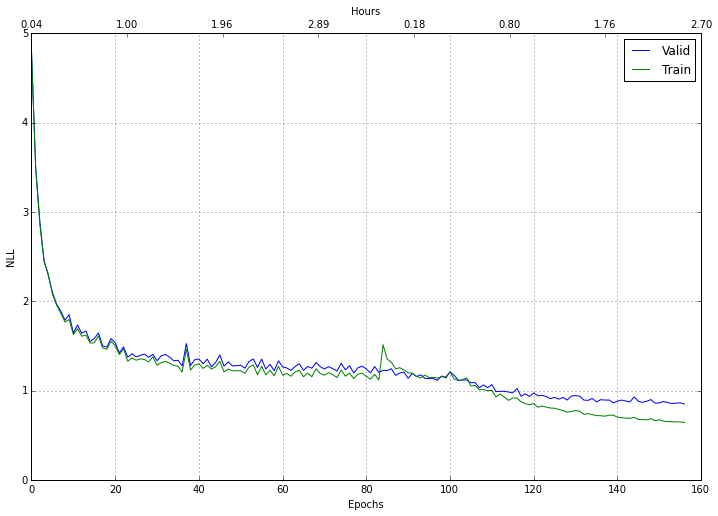

In [238]:
tr = np.array(model.monitor.channels['valid_y_y_1_nll'].time_record) / 3600.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(model.monitor.channels['valid_y_y_1_nll'].val_record)
ax1.plot(model.monitor.channels['train_y_y_1_nll'].val_record)
ax1.set_xlabel('Epochs')
ax1.legend(['Valid', 'Train'])
ax1.set_ylabel('NLL')
ax1.set_ylim(0., 5.)
ax1.grid(True)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,tr.shape[0],20))
ax2.set_xticklabels(['{0:.2f}'.format(t) for t in tr[::20]])
ax2.set_xlabel('Hours')
print("Minimum validation set NLL {0}".format(min(model.monitor.channels['valid_y_y_1_nll'].val_record)))

## Visualising first layer weights
Quite nice features appear to have been learned with some kernels appearing to have been learned at various rotations. Some quite small scale features appear to have been learned too.

smallest enc weight magnitude: 0.000601768319029
mean enc weight magnitude: 0.145944297314
max enc weight magnitude: 0.852994024754


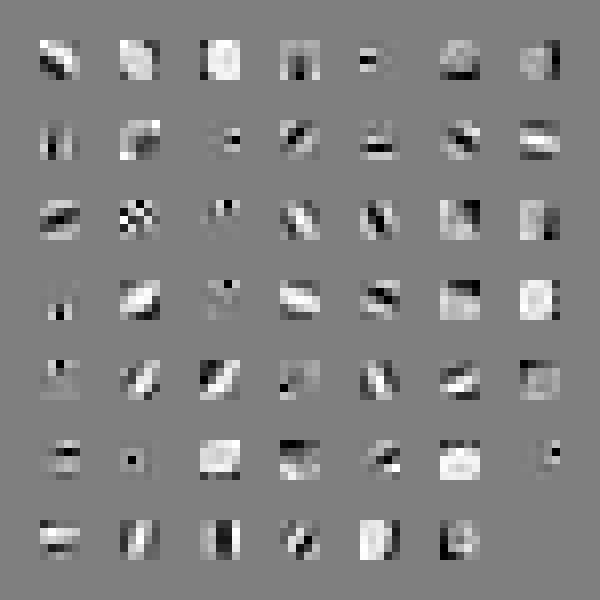

In [195]:
pv = get_weights_report(model=model)
img = pv.get_img()
img = img.resize((8*img.size[0], 8*img.size[1]))
img_data = io.BytesIO()
img.save(img_data, format='png')
display(Image(data=img_data.getvalue(), format='png'))

## Learning rate

Initially linear decay learning rate schedule used with monitor based adjuster. Turns out these don't play well together as the linear decay schedule overwrites any adjusments by monitor based extension at the next epoch. After resume initial learning rate manually reduced and learning rate schedule set exclusively with monitor based adjuster.

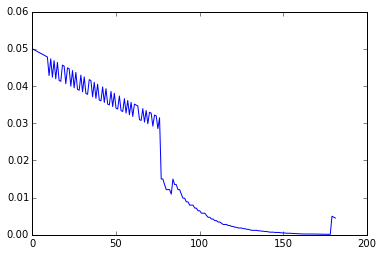

In [224]:
plt.plot(model.monitor.channels['learning_rate'].val_record)

## Update norm monitoring
Ratio of update norms to parameter norms across epochs for different layers plotted to give idea of how learning rate schedule performing.

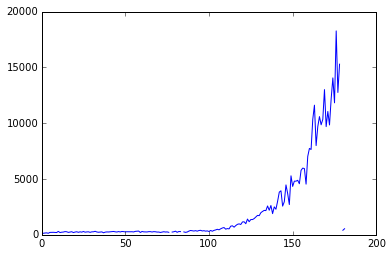

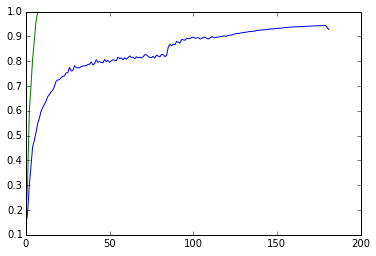

In [225]:
h1_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h1_W_kernel_norm_mean'].val_record])
h1_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h1_kernel_norms_mean'].val_record])
plt.plot(h1_W_norms / h1_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h1_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h1_kernel_norms_max'].val_record)

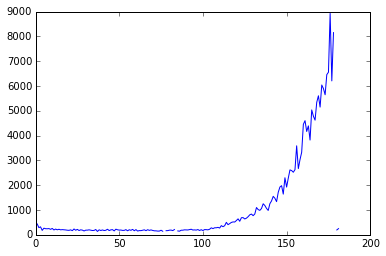

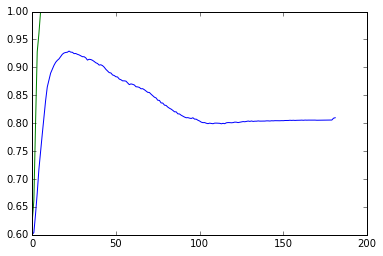

In [226]:
h2_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h2_W_kernel_norm_mean'].val_record])
h2_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h2_kernel_norms_mean'].val_record])
plt.plot(h2_W_norms / h2_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h2_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h2_kernel_norms_max'].val_record)

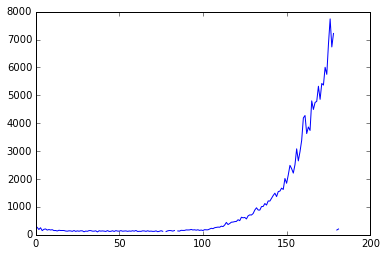

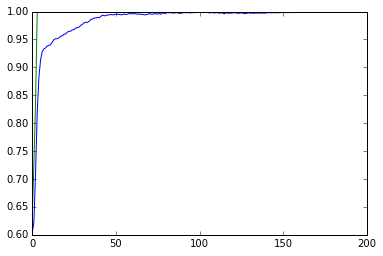

In [227]:
h3_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h3_W_kernel_norm_mean'].val_record])
h3_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h3_kernel_norms_mean'].val_record])
plt.plot(h3_W_norms / h3_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h3_kernel_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h3_kernel_norms_max'].val_record)

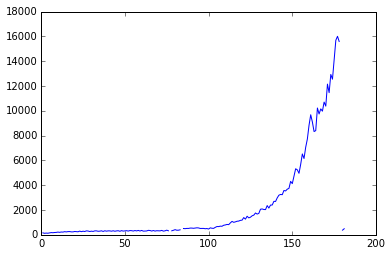

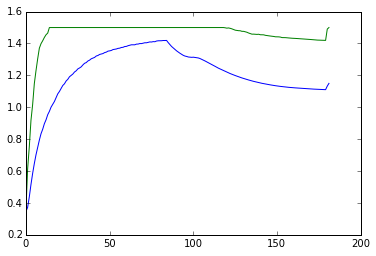

In [228]:
h4_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h4_W_col_norm_mean'].val_record])
h4_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h4_col_norms_mean'].val_record])
plt.plot(h4_W_norms / h4_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h4_col_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h4_col_norms_max'].val_record)

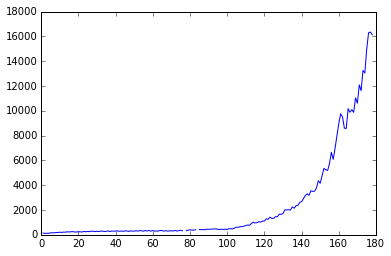

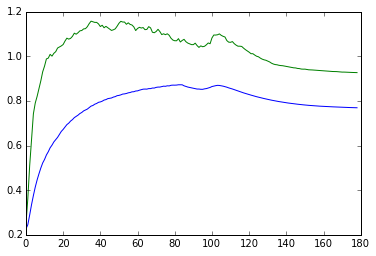

In [221]:
h5_W_up_norms = np.array([float(v) for v in model.monitor.channels['mean_update_h5_W_col_norm_mean'].val_record])
h5_W_norms = np.array([float(v) for v in model.monitor.channels['valid_h5_col_norms_mean'].val_record])
plt.plot(h5_W_norms / h5_W_up_norms)
plt.show()
plt.plot(model.monitor.channels['valid_h5_col_norms_mean'].val_record)
plt.plot(model.monitor.channels['valid_h5_col_norms_max'].val_record)